In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from osgeo import gdal
import os
import re
import cv2 as cv
import h5py
import numpy as np
import tensorflow as tf
import tifffile as tiff
from tensorflow.keras.models import load_model
from keras.preprocessing.image import save_img
#import tifffile as tiff
#from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy as cce
#from skimage import exposure
from PIL import Image
from skimage.exposure import adjust_sigmoid, is_low_contrast
from sklearn.decomposition import PCA


In [ ]:
##This is the prediction for test image builtup 6channels input image ndvi and ndwi



#!pip install tf-nightly-gpu-2.0-preview

'''
def iou(y_true, y_pred):
    #y_true = y_true[:,size//10:9*size//10, size//10:9*size//10,:]
    #y_pred = y_pred[:,size//10:9*size//10, size//10:9*size//10,:]
    smooth = 1e-12
   
    intersection = K.sum((y_true * y_pred), axis = (0,1,2))
    intrsctn = K.sum(intersection[2])
    union = K.sum((y_true + y_pred), axis = (0,1,2)) - K.sum((y_true * y_pred), axis = (0,1,2))
    unin = K.sum(union[2])
    #iu = K.sum((intersection + smooth)/ (union + smooth))
    iu = K.sum((intrsctn+smooth)/(unin+smooth))
    return iu
    

def iou_loss(y_true, y_pred):
    ncl = 1.0
    return (ncl-iou(y_true, y_pred))


def dice(y_true, y_pred):
    #y_true = y_true[:,size//10:9*size//10, size//10:9*size//10,:]
    #y_pred = y_pred[:,size//10:9*size//10, size//10:9*size//10,:]
    
    smooth1 = 1e-12
    #w1 = K.sum(y_true)
    #w2 = K.sum(1-y_true) 
    num1 = K.sum((y_true *  y_pred), axis = (0,1,2))
    dnm1 = K.sum((y_true +  y_pred), axis = (0,1,2))     
    num2 = K.sum(num1[2])
    dnm2 = K.sum(dnm1[2])
    #num2 = K.sum(((1-y_true) * (1- y_pred)), axis = (0,1,2,3))
    #dnm2 = K.sum((2- y_true -  y_pred), axis = (0,1,2,3))     
    
    #f1 = ((2*num1 + smooth1)/ (dnm1 + smooth1)) #+ w1*((2*num2 + smooth1)/ (dnm2 + smooth1)))/(w1+w2)
    f1 = K.sum((2*num2 + smooth1)/ (dnm2 + smooth1))
    return f1
 
def dice_loss(y_true, y_pred):
    ncl = 1.0
    return (ncl-dice(y_true, y_pred)) #+ 0.5*(bce(y_true, y_pred)))
'''

def iou(y_true, y_pred):
    smooth = 1e-12
    '''
    size =int(256)
    y_true = K.cast(K.reshape(y_true, (-1,size,size)),np.uint8)
    y_true = K.one_hot(y_true,3)
    '''
    intersection = K.sum((y_true * y_pred), axis = (0,1,2))
    #intrsctn = K.sum(intersection[1:])
    #intrsctn = K.sum(intersection[1]+intersection[2]+intersection[4])
    union = K.sum((y_true + y_pred), axis = (0,1,2)) - K.sum((y_true * y_pred), axis = (0,1,2))
    #unin = K.sum(union[1:])
    #unin = K.sum(union[1]+union[2]+union[4])
    
    iu = ((intersection + smooth)/ (union + smooth))
    #iu = K.sum((intrsctn+smooth)/(unin+smooth))
    return K.mean(iu)#+iu[2]+iu[4]+iu[8]+iu[9])
    

def iou_loss(y_true, y_pred):
    ncl = 1.0
    return (ncl-iou(y_true, y_pred))


 
def dice(y_true, y_pred):
    smooth1 = 1e-12
    '''
    size = int(256)
    y_true = K.cast(K.reshape(y_true, (-1,size,size)),np.uint8)
    y_true = K.one_hot(y_true,3)
    #class_weights = K.sum(y_true, axis = (0,1,2,3))/(K.sum(y_true, axis = (0,1,2,3)) + K.sum((1 -y_true), axis = (0,1,2,3)))
    #y_pred = weighted_ypred(y_true,y_pred)
    '''
    #w1 = K.sum(y_true)
    #w2 = K.sum(1-y_true) 
    num1 = K.sum((y_true *  y_pred), axis = (0,1,2))
    dnm1 = K.sum((y_true +  y_pred), axis = (0,1,2))     
    '''
    num2 = K.sum(num1[1:])
    dnm2 = K.sum(dnm1[1:])
    '''
    '''
    num2 = K.sum(num1[1]+num1[2]+num1[4])
    dnm2 = K.sum(dnm1[1]+dnm1[2]+dnm1[4])
    '''
    #num2 = K.sum(num1)
    #dnm2 = K.sum(dnm1)


    #num2 = K.sum(((1-y_true) * (1- y_pred)), axis = (0,1,2,3))
    #dnm2 = K.sum((2- y_true -  y_pred), axis = (0,1,2,3))     
    
    f1 = ((2*num1 + smooth1)/ (dnm1 + smooth1)) #+ w1*((2*num2 + smooth1)/ (dnm2 + smooth1)))/(w1+w2)
    #f1 = K.sum((2*num2 + smooth1)/ (dnm2 + smooth1))
    return K.mean(f1)#+f1[2]+f1[4]+f1[8]+f1[9])
 
def dice_loss(y_true, y_pred):
    ncl = 1.0
    return (ncl-dice(y_true, y_pred))

def comb_acc(y_true, y_pred):
    return (dice(y_true, y_pred) + iou(y_true, y_pred))/2

def comb_loss(y_true, y_pred):
    return (dice_loss(y_true, y_pred))

def raster2arr(raster, bnd,x,y,wndox,wndoy):
    rr = np.zeros((wndoy, wndox, bnd))
    newValue = 0
    for b in range(bnd):
        band = raster.GetRasterBand(b+1)
        img = band.ReadAsArray(x, y, wndox, wndoy)
        noDataValue = band.GetNoDataValue()
        img[img == noDataValue] = newValue
        rr[:,:,b] = img
    return rr.astype(np.uint8)

def add_veg_water_index(image):
    h,w = image.shape[:2]
    image2= np.zeros((h,w,6))
    image2[:,:,:4] = image
    del image
    r = image2[:,:,2]
    g = image2[:,:,1]
    nir = image2[:,:,3]
    
    num1 = nir-r
    dnm1 = nir+r
    num2= g-nir
    dnm2 = g+nir
    
    del nir,r,g
    ndvi = np.divide(num1,dnm1, where = (dnm1!=0), dtype = np.float64)
    ndwi = np.divide(num2,dnm2, where = (dnm2!=0), dtype = np.float64)
    
    del num1,num2,dnm1,dnm2
    ndvi[ndvi>1] = 0
    ndvi[ndvi<-1] = 0
    ndwi[ndwi>1] = 0
    ndwi[ndwi<-1] = 0
    
    image2[:,:,4] = 127.5 + ndvi*127.5
    image2[:,:,5] = 127.5 + ndwi*127.5
    
    return image2,ndvi,ndwi


def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
  
  
def get_all_images(folder, ext):

    all_files = []
    fname = []
    #Iterate through all files in folder
    for file in sorted_aphanumeric(os.listdir(folder)):
        #Get the file extension
        basename,  file_ext = os.path.splitext(file)

        #If file is of given extension, get it's full path and append to list
        if ext in file_ext:
            full_file_path = os.path.join(folder, file)
            all_files.append(full_file_path)
            fname.append(basename)
    #Get list of all files
    return all_files,fname

def batch_predict(filepath,model,hi=0,wi=0):
    raster = gdal.Open(filepath)


    w,h = round(raster.RasterXSize), round(raster.RasterYSize)
    ##########image1 = (raster2array(raster,4,0,0,w,h)).astype(np.uint8)
    image1 = (raster2arr(raster,4,0,0,w,h)).astype(np.uint8)
    raster = None       
    size = 256
    h,w,d = image1.shape
    
    ints1 = list(range(hi,h+1,size))
    ints2 = list(range(wi,w+1,size))

    i = len(ints1)
    j = len(ints2)

        
    image2 = np.zeros((h,w))
    print('predicting')
    
    
    m=1
    for k in ints1[0:-1]:
        p = 0
        arr = np.zeros(((j-1),size,size,d+2))
        img = np.zeros((size,size,d))
        for n in ints2[0:-1]:
            img = image1[k:(k+size), n:(n+size),:]
            
            arr[p,:,:,:],ndvi,ndwi = add_veg_water_index(img)
            
            del img,ndvi,ndwi
            
            p+=1
        # arr = arr/255.0    
        arr = (model.predict(arr, verbose = 0))
        arr = np.argmax(arr, axis = 3)
        
        ##arr = np.around(np.squeeze(arr))
        
        #print(m, '/',(i-1), end="\r")
        print("\r", m, '/',(i-1), end=" ")
        p = 0
        for n in ints2[0:-1]:
            image2[k:(k+size), n:(n+size)] = arr[p,:,:]
            p+=1
        m+=1
    p = 0
    arr = np.zeros(((i-1),size,size,d+2))
    for k in ints1[0:-1]:
        img = np.zeros((size,size,d))
        #for n in ints2[0:-1]:
        img = image1[k:(k+size), w-size:w,:]
        ##arr[p,:,:,:d] = img
        arr[p,:,:,:],ndvi,ndwi = add_veg_water_index(img)
    
        del img,ndvi,ndwi
        
        p+=1
    # arr = arr/255.0    
    arr = (model.predict(arr, verbose = 0))
    arr = np.argmax(arr, axis = 3)

    ##arr = np.around(np.squeeze(arr))

    #print(m, '/',(i-1), end="\r")
    print('adjusted height')
    p = 0
    for k in ints1[0:-1]:
        image2[k:(k+size), w-size:w] = arr[p,:,:]
        p+=1
    
    p = 0
    arr = np.zeros(((j-1),size,size,d+2))   
    for n in ints2[0:-1]:
        img = np.zeros((size,size,d))
        img = image1[h-size:h, n:(n+size),:]
        
        arr[p,:,:,:],ndvi,ndwi = add_veg_water_index(img)

        del img,ndvi,ndwi
        
        p+=1
    # arr = arr/255.0    
    arr = (model.predict(arr, verbose = 0))
    arr = np.argmax(arr, axis = 3)

    ##arr = np.around(np.squeeze(arr))

    #print(m, '/',(i-1), end="\r")
    print('adjusted width')
    p = 0
    for n in ints2[0:-1]:
        image2[h-size:h, n:(n+size)] = arr[p,:,:]
        p+=1
    img = (image1[h-size:h, w-size:w,:])  
    arr1 = np.zeros((1,size,size,d+2))
    arr1[0,:,:,:],ndvi,ndwi = add_veg_water_index(img)

    del img,ndvi,ndwi
    
    # arr1 = arr1/255.0    

    
    arr1 = (model.predict(arr1, verbose = 0))
    arr1 = np.argmax(arr1, axis = 3)
    image2[h-size:h, w-size:w] = arr1
    image2[image2==0]=6
    ##image2[h-size:h, w-size:w] = np.around(np.squeeze(arr1))
    image2[(image1[:,:,0]==0)&(image1[:,:,1]==0)&(image1[:,:,2]==0)&(image1[:,:,3]==0)]=0
    return image2.astype(np.uint8)





In [ ]:
folder_img = '/content/drive/My Drive/Excel/vietnam images'
folder_label = '/content/drive/My Drive/Excel/kmean_gpu_pred2'
mpath = "/content/drive/My Drive/Excel/vietnam_kmeans_gpu_label1.h5"
flist,fnamelist = ((get_all_images(folder_img, 'img')))
K.clear_session()
model = load_model(mpath, custom_objects={'dice_loss': dice_loss,'iou': iou, 'dice': dice})
#model = load_model(mpath, custom_objects={'iou': iou, 'dice': dice})

size = 256

for f, fns in enumerate(flist):
    
    image = batch_predict(fns,model)
    h,w = image.shape[:2]
    print(image.shape)
    
    # image2 = batch_predict(fns,model,size//2,0)
    # image3 = batch_predict(fns,model,0,size//2)
    # image4 = batch_predict(fns,model,size//2,size//2)
    
    '''
    image1 = np.zeros_like(image)
    image2 = np.zeros_like(image)
    image3 = np.zeros_like(image)
    image4 = np.zeros_like(image)
    image1[image==1] = 1
    image2[image==2] = 1
    image3[image==3] = 1
    image4[image==4] = 1
    image1 = image*image1
    image1 = image1[:,:,1:]
    for i in range(1,5):
        image2 = np.zeros_like(image)

    '''
     
    ints1 = list(range(0,h+1,size))
    ints2 = list(range(0,w+1,size))

    # print('0123456789: ',  np.sum((image[image==0])+1), np.sum((image[image==1])), np.sum((image[image==2])/2), np.sum((image[image==3])/3), np.sum((image[image==4])/4),np.sum((image[image==5])/5),np.sum((image[image==6])/6),np.sum((image[image==7])/7),np.sum((image[image==8])/8),np.sum((image[image==9])/9))
    
    # m=1
    # for k in ints1[0:-1]:
    #     image[(k-size//4):(k+size//4),:] = image2[(k-size//4):(k+size//4),:]
    #     #image[(k-10):(k+10),:] = image2[(k-10):(k+10),:]   
    # for n in ints2[0:-1]:
    #     image[:, (n-size//4):(n+size//4)] = image3[:, (n-size//4):(n+size//4)]
    #     #image[:, (n-10):(n+10)] = image3[:, (n-10):(n+10)]        
    # for k in ints1[0:-1]:
    #     for n in ints2[0:-1]:
    #         image[(k-size//4):(k+size//4),(n-size//4):(n+size//4)] = image4[(k-size//4):(k+size//4),(n-size//4):(n+size//4)]       
    # del image2,image3,image4
    
    # ##image1[image==image2==image3==image4]
    #image1[(image2==0)&(image3==0)&(image4==0)] = 0
    
    print('0123456789: ',  np.sum((image[image==0])+1), np.sum((image[image==1])), np.sum((image[image==2])/2), np.sum((image[image==3])/3), np.sum((image[image==4])/4),np.sum((image[image==5])/5),np.sum((image[image==6])/6),np.sum((image[image==7])/7),np.sum((image[image==8])/8),np.sum((image[image==9])/9))
    #print(np.unique(image, return_counts=True))
    
    #print(image.shape)
    cv.imwrite(folder_label+"/{}_pred1.tif".format(fnamelist[f]), image.astype(np.uint8))       
    ##cv.imwrite("/content/drive/My Drive/Excel/vietnam_5_veg_try2_train2/{}_pred1.tif".format(fnamelist[f]), image.astype(np.uint8))       
    ##cv.imwrite("/content/drive/My Drive/Excel/vietnam_5_water_try3_train2/{}_pred1.tif".format(fnamelist[f]), image.astype(np.uint8))       
    print('image {} saved'.format(f))
    del image


In [ ]:
from matplotlib import pyplot as plt
def visual(h, w, i, img ):
    fig = plt.figure(figsize=(2, 2), dpi=512)
    ax = plt.subplot(h, w, i)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.title.set_text('images_{}'.format(i-1))
    plt.imshow(img, cmap = 'jet')


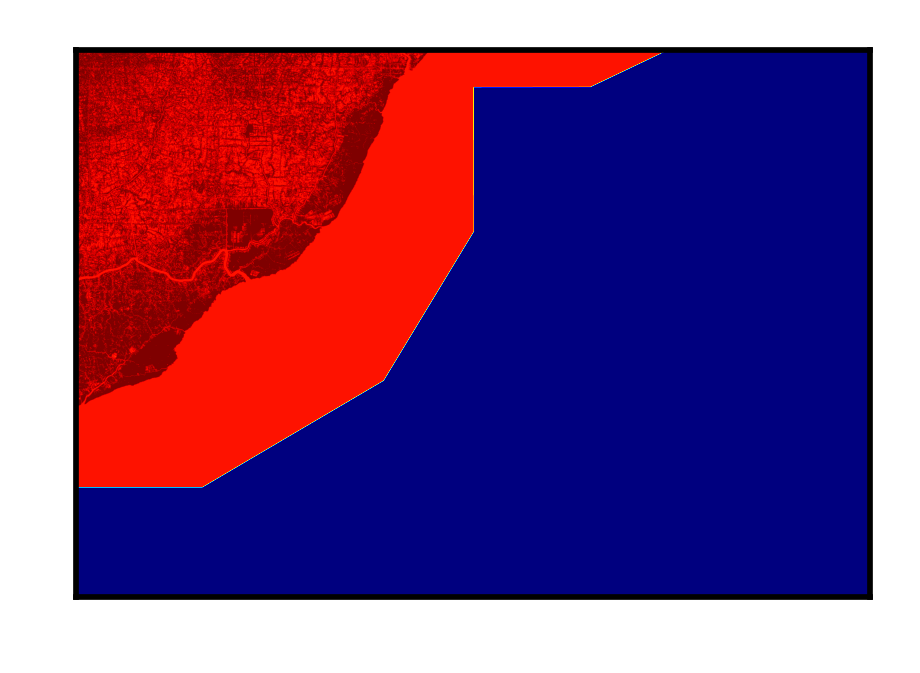

In [ ]:
flist2,fnamelist2 = ((get_all_images(folder_label, 'tif')))
i=3
raster = gdal.Open(flist2[i])
w,h = round(raster.RasterXSize), round(raster.RasterYSize)
image1 = (raster2arr(raster,1,0,0,w,h)).astype(np.uint8)
raster = None   
visual(1,1,1,image1.reshape((h,w)))    

In [ ]:
def norm_classes(img1,img2,ndvi,ndwi,nClasses):
    
    for c in list(set(img1.flatten())):
        mask = np.zeros_like(img1)
        mask[img1==c] =1
        mean_ndvi = np.sum(ndvi[img1==c])/np.sum(mask)
        mean_ndwi = np.sum(ndwi[img1==c])/np.sum(mask)
        if (mean_ndvi<0.2 and mean_ndvi>0 and mean_ndwi<0):
            img2[img1==c] = 7
        elif (mean_ndvi<0.4 and mean_ndvi>=0.2):
            img2[img1==c] = 8
        elif (mean_ndvi>=0.4):
            img2[img1==c] = 9
        elif (mean_ndwi>=0.3):
            img2[img1==c] = 1 
        elif (mean_ndvi<0.2 and mean_ndwi<0.3 and mean_ndwi>0.1):
            img2[img1==c] = 2 
        elif (mean_ndvi<0 and mean_ndwi<0):
            img2[img1==c] = 3
        elif (mean_ndvi<=0.2 and mean_ndvi>0 and mean_ndwi<=0.1 and mean_ndwi>0):
            img2[img1==c] = 4 
        elif (mean_ndvi<=0.2 and mean_ndvi>0 and mean_ndwi<=0):
            img2[img1==c] = 5 
        else:
            img2[img1==c] = 6
    return img2

def get_veg_water_index(image):
           
    h,w = image.shape[:2]
    
    # del image
    r = image[:,:,2]
    g = image[:,:,1]
    nir = image[:,:,3]
     
    num1 = nir-r
    dnm1 = nir+r
    num2= g-nir
    dnm2 = g+nir
    
    del nir,r,g
    ndvi = np.divide(num1,dnm1, where = (dnm1!=0), dtype = np.float64)
    ndwi = np.divide(num2,dnm2, where = (dnm2!=0), dtype = np.float64)
    
    del num1,num2,dnm1,dnm2
    ndvi[ndvi>1] = 0
    ndvi[ndvi<-1] = 0
    ndwi[ndwi>1] = 0
    ndwi[ndwi<-1] = 0
    
    
    return ndvi,ndwi

def post_process(fpath1,fpath2,nClasses,hi,wi):
    
    raster = gdal.Open(fpath1)


    w,h = round(raster.RasterXSize), round(raster.RasterYSize)
    image = np.zeros((h,w,1))
    raster = None       
    size = 256    
   
    ints1 = list(range(hi,h+1,size))
    ints2 = list(range(wi,w+1,size))

    i = len(ints1)
    j = len(ints2)
    m=1
    for k in ints1[0:-1]:
        img = np.zeros((size,size,4))
        img1 = np.zeros((size,size))
        img2 = np.zeros((size,size))

        
        for n in ints2[0:-1]:
            raster = gdal.Open(fpath1)
            img = raster2arr(raster,4,n,k,size,size)
            raster = None  
            ndvi,ndwi = get_veg_water_index(img)
            
            raster = gdal.Open(fpath2)
            img1 = raster2arr(raster,1,n,k,size,size).reshape(size,size)
            raster = None
            img2 = norm_classes(img1,img2,ndvi,ndwi,nClasses)

            image[k:(k+size), n:(n+size),0] = img2

        print("\r", m, '/',i-1, end=" ")
        m+=1

    for k in ints1[0:-1]:
        img1 = np.zeros((size,size))
        img2 = np.zeros((size,size))

        raster = gdal.Open(fpath1)
        img = raster2arr(raster,4,(w-size),k,size,size)
        raster = None
        ndvi,ndwi = get_veg_water_index(img)
        raster = gdal.Open(fpath2)
        img1 = raster2arr(raster,1,(w-size),k,size,size).reshape(size,size)
        raster = None
        img2 = norm_classes(img1,img2,ndvi,ndwi,nClasses)

        image[k:(k+size), (w-size):w,0] = img2

    for n in ints2[0:-1]:
        img1 = np.zeros((size,size))
        img2 = np.zeros((size,size))

        raster = gdal.Open(fpath1)
        img = raster2arr(raster,4,n,h-size,size,size)
        raster = None
        ndvi,ndwi = get_veg_water_index(img)
        raster = gdal.Open(fpath2)
        img1 = raster2arr(raster,1,n,h-size,size,size).reshape(size,size)
        raster = None
        img2 = norm_classes(img1,img2,ndvi,ndwi,nClasses)

        image[(h-size):h, n:(n+size),0] = img2

    img1 = np.zeros((size,size))
    img2 = np.zeros((size,size))

    raster = gdal.Open(fpath1)
    img = raster2arr(raster,4,w-size,h-size,size,size)
    raster = None
    ndvi,ndwi = get_veg_water_index(img)
    raster = gdal.Open(fpath2)
    img1 = raster2arr(raster,1,w-size,h-size,size,size).reshape(size,size)
    raster = None
    img2 = norm_classes(img1,img2,ndvi,ndwi,nClasses)

    image[(h-size):h, (w-size):w,0] = img2

    return image

folder_img = '/content/drive/My Drive/Excel/multiclass_unsup/img'
folder_lbl = '/content/drive/My Drive/Excel/multiclass_unsup/label1'

nClasses = 10
flist_img,fnamelist_img = ((get_all_images(folder_img, 'img')))
flist_lbl,fnamelist_lbl = ((get_all_images(folder_lbl, 'tif')))
assert len(flist_img) == len(flist_lbl)

# for f in range(len(flist_img)):
for f in range(len(flist[2])):
    image = post_process(flist_img[f],flist_lbl[f],nClasses,0,0)
    print("processed 1/4")
#     image1 = post_process(flist_img[f],flist_lbl[f],nClasses,size//2,0)
#     print("processed 2/4")
#     image2 = post_process(flist_img[f],flist_lbl[f],nClasses,0,size//2)
#     print("processed 3/4")
#     image3 = post_process(flist_img[f],flist_lbl[f],nClasses,size//2,size//2)
#     print("processed 4/4")

#     raster = gdal.Open(flist_img[f])


#     w,h = round(raster.RasterXSize), round(raster.RasterYSize)
#     raster = None       
#     size = 256    
   
#     ints1 = list(range(0,h+1,size))
#     ints2 = list(range(0,w+1,size))

#     i = len(ints1)
#     j = len(ints2)
#     m=1
#     for k in ints1[0:-1]:
#         image[(k-size//4):(k+size//4),:] = image1[(k-size//4):(k+size//4),:]
#         #image[(k-10):(k+10),:] = image2[(k-10):(k+10),:]   
#     for n in ints2[0:-1]:
#         image[:, (n-size//4):(n+size//4)] = image2[:, (n-size//4):(n+size//4)]
#         #image[:, (n-10):(n+10)] = image3[:, (n-10):(n+10)]        
#     for k in ints1[0:-1]:
#         for n in ints2[0:-1]:
#             image[(k-size//4):(k+size//4),(n-size//4):(n+size//4)] = image3[(k-size//4):(k+size//4),(n-size//4):(n+size//4)]

    

 42 / 42 processed 1/4


In [ ]:

cv.imwrite("/content/drive/My Drive/Excel/multiclass_unsup/pws_best2_treated.tif", image.astype(np.uint8))       

True

In [ ]:
raster = gdal.Open(flist[0])
image1 = raster2arr(raster,4,0,0,10980,10980)
raster = None
ndvi,ndwi = get_veg_water_index(image1)
del image1
print("raster loaded")


raster loaded


In [ ]:
import cv2 as cv
image = cv.imread("/content/drive/My Drive/Excel/multiclass_unsup/unsup_pred/t48pwr_20180312_re_inter_pred_1.tif",0)


In [ ]:
print(image.shape)

(10980, 10980)


In [ ]:
for i in list(set(image.flatten())):
    mask = np.zeros_like(image)
    mask[image==i] =1
    print(ndvi.shape,mask.shape)
    mask = mask.reshape(10980,10980)
    total = np.sum(mask)
    print(i,":",total)
    print(np.sum(ndvi[mask==1])/total,np.sum(ndwi[mask==1])/total)

(10980, 10980) (10980, 10980)
0 : 101
0.3249999813659874 0.02748153642406841
(10980, 10980) (10980, 10980)
1 : 5180588
0.0016978474008033499 0.46909934145592697
(10980, 10980) (10980, 10980)
2 : 7206759
0.23652152608958318 0.011459642500473618
(10980, 10980) (10980, 10980)
3 : 27
0.20965887070479444 0.0635537644477619
(10980, 10980) (10980, 10980)
4 : 169
0.28476208312289497 0.02818852696388351
(10980, 10980) (10980, 10980)
5 : 9985770
0.13874623960095614 0.034184819396945794
(10980, 10980) (10980, 10980)
6 : 522
0.267095871865315 0.04256915359219598
(10980, 10980) (10980, 10980)
7 : 709137
0.16793614555365585 0.09813390021260458
(10980, 10980) (10980, 10980)
8 : 44257949
0.5010498144993092 3.9905544384495996e-05
(10980, 10980) (10980, 10980)
9 : 53219378
0.6934677872352972 4.5672011578820183e-08


In [ ]:
for i in list(set(image.flatten())):
    mask = np.zeros_like(image)
    mask[image==i] =1
    print(ndvi.shape,mask.shape)
    mask = mask.reshape(10980,10980)
    total = np.sum(mask)
    print(i,":",total)
    print(np.sum(ndvi[mask==1])/total,np.sum(ndwi[mask==1])/total)

(10980, 10980) (10980, 10980, 1)
1.0 : 4936327.0
0.012908943872445169 0.45731053945862415
(10980, 10980) (10980, 10980, 1)
2.0 : 2961058.0
0.07064727012435529 0.17499387035367667
(10980, 10980) (10980, 10980, 1)
4.0 : 4953637.0
0.1497268925266302 0.014799819082677098
(10980, 10980) (10980, 10980, 1)
5.0 : 546.0
0.1624458439196849 0.0
(10980, 10980) (10980, 10980, 1)
8.0 : 19793364.0
0.31330835535891177 0.0025937021520269607
(10980, 10980) (10980, 10980, 1)
9.0 : 87915468.0
0.6265495123396061 0.0002877432662536518


In [ ]:
from matplotlib import pyplot as plt
def visual(h, w, i, img ):
    fig = plt.figure(figsize=(2, 2), dpi=512)
    ax = plt.subplot(h, w, i)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.title.set_text('images_{}'.format(i-1))
    plt.imshow(img, cmap = 'jet')


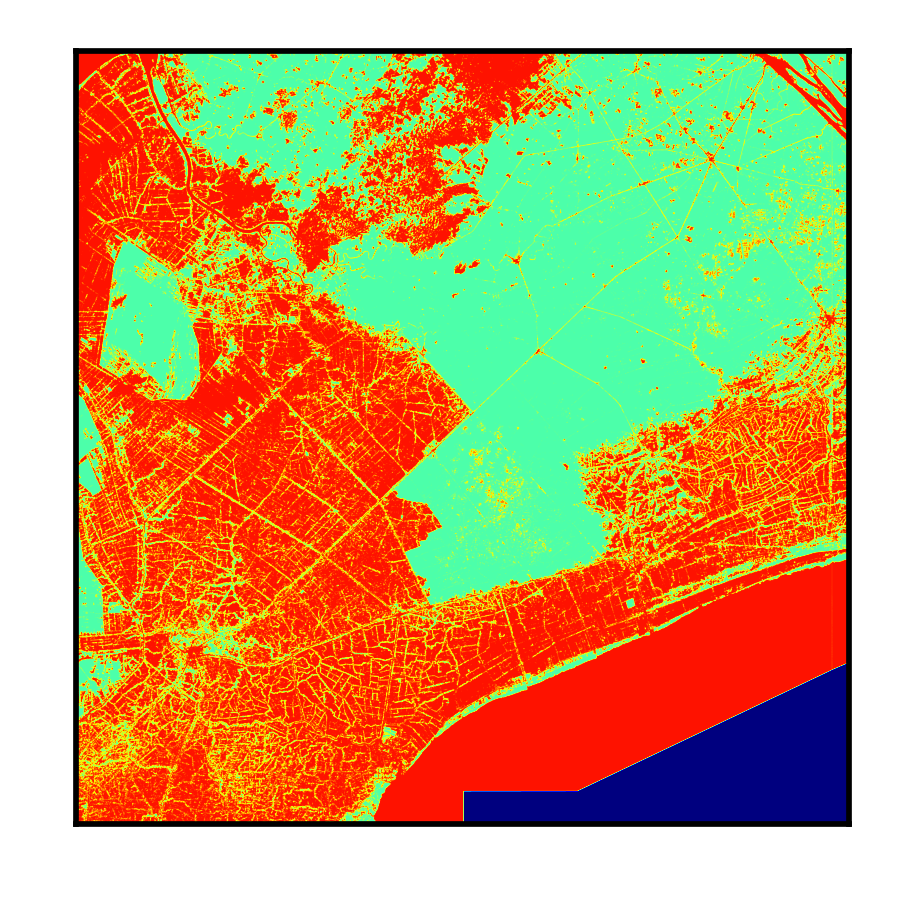

In [ ]:
# for pred 1 output
h,w = image.shape[:2]
visual(1,1,1,image.reshape((h,w)))

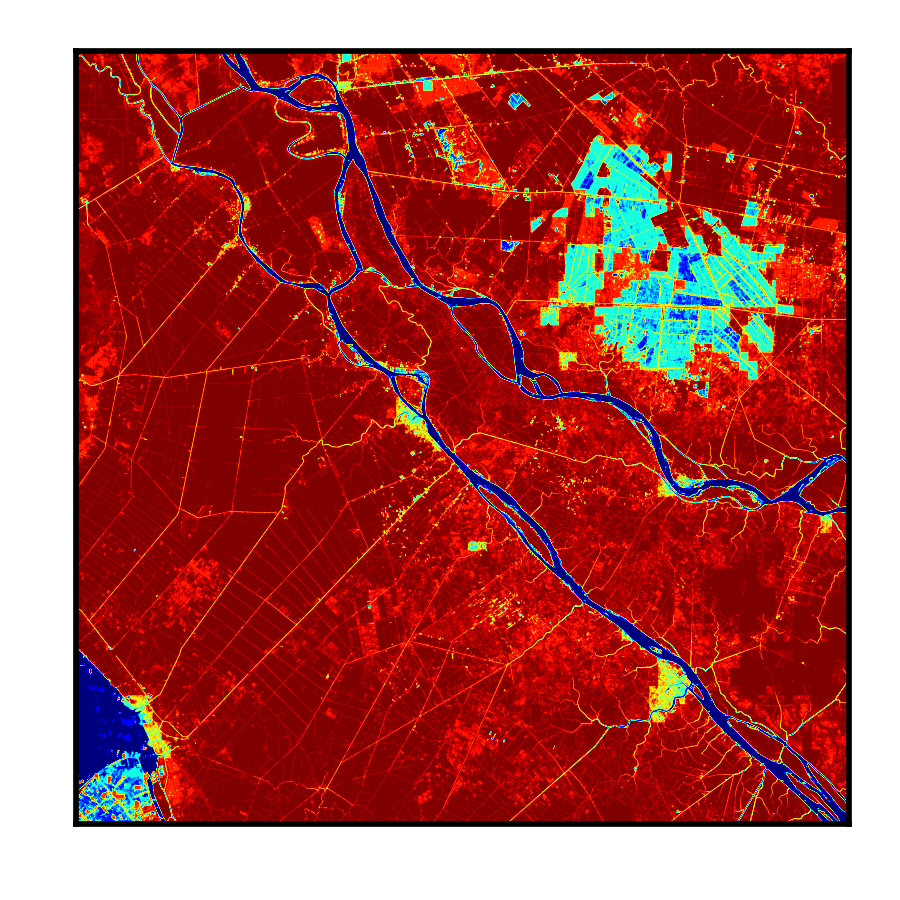

In [ ]:
# for kmeans best 2 output post processed
h,w = 10980,10980
visual(1,1,1,image.reshape((h,w)))

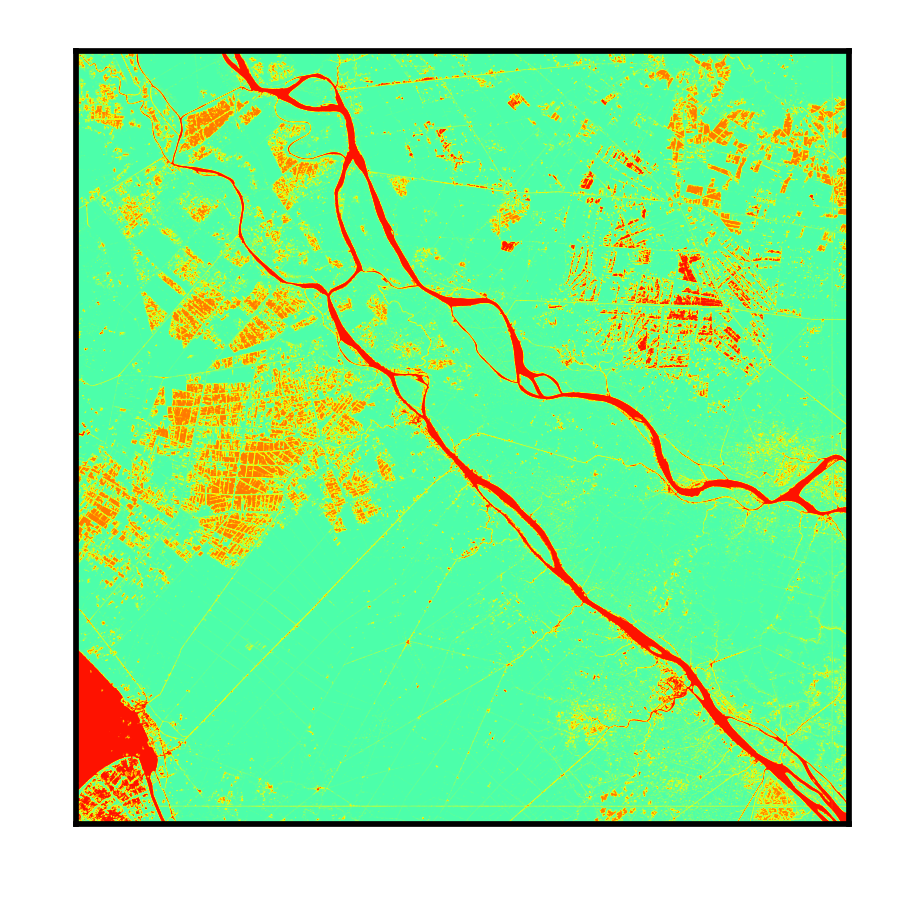

In [ ]:
# for kmeans output
h,w = 10980,10980
visual(1,1,1,image.reshape((h,w)))

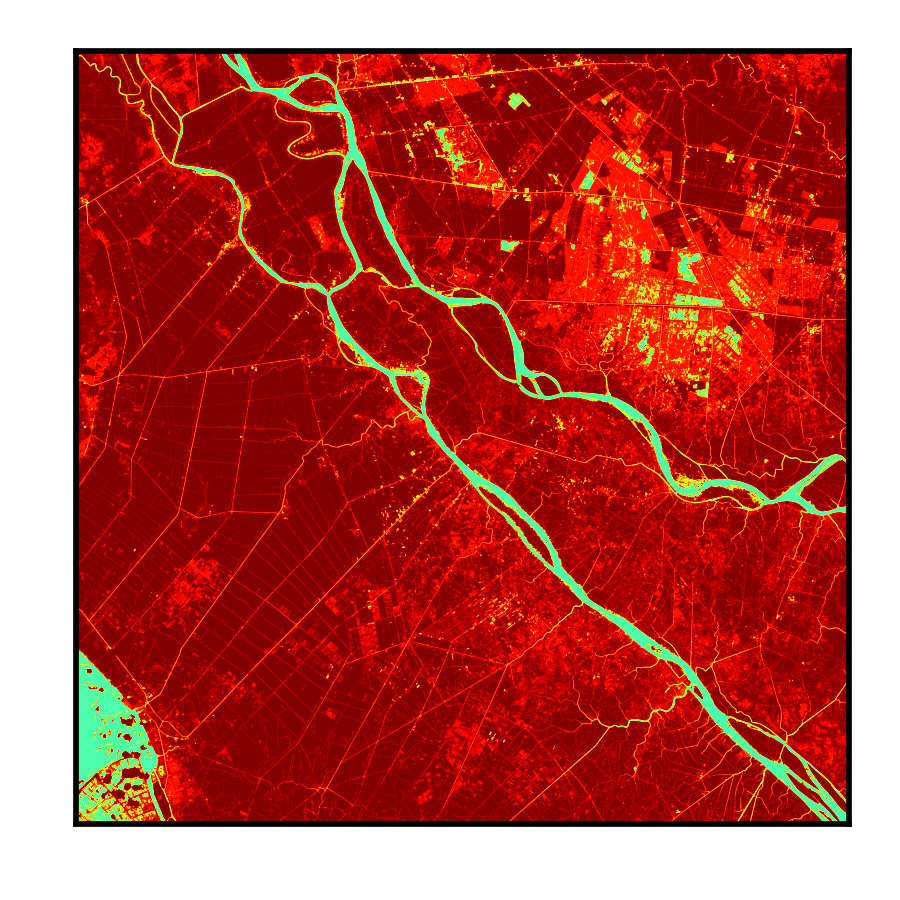

In [ ]:
# for model/iteration3
visual(1,1,1,image.reshape((h,w)))

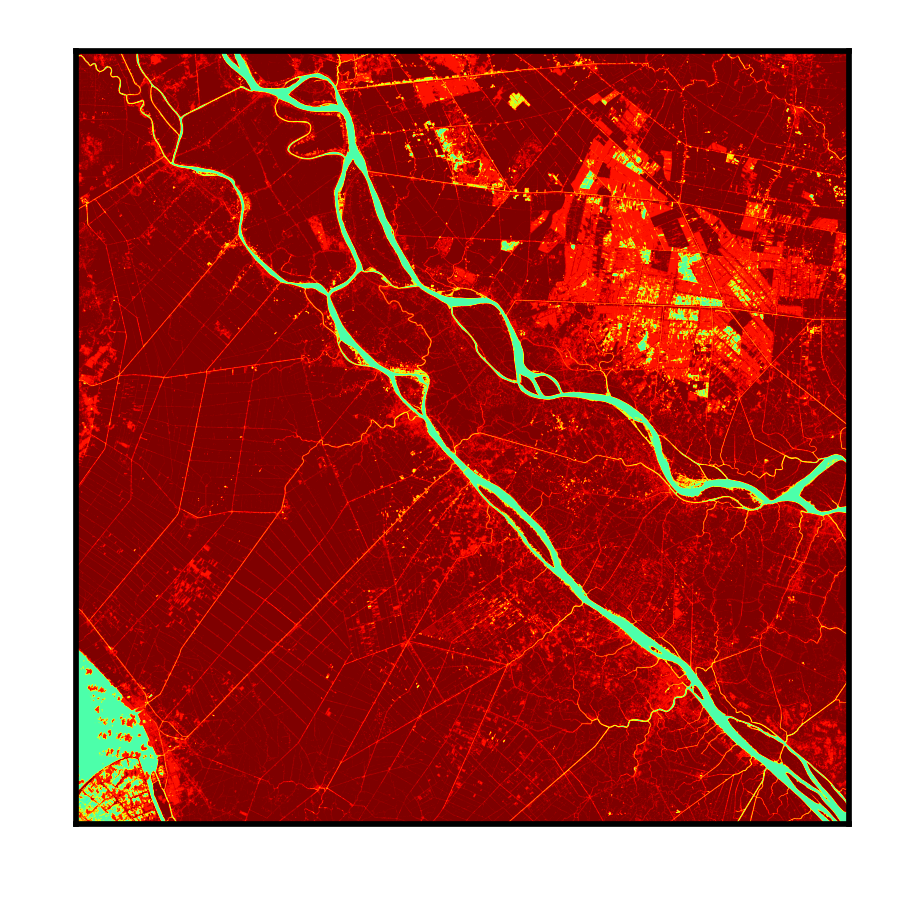

In [ ]:
# for model1/iteration2
visual(1,1,1,image.reshape((h,w)))

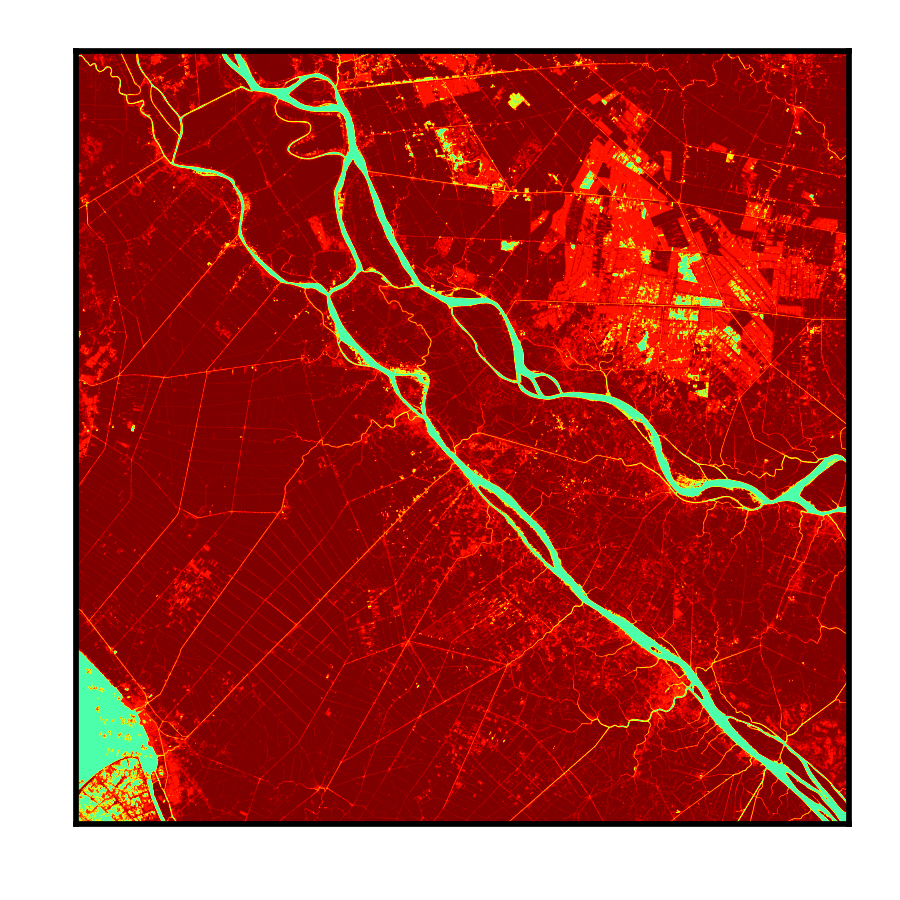

In [ ]:
# for model 2 iteration 1
visual(1,1,1,image.reshape((h,w)))

In [ ]:
path = '/content/drive/MyDrive/Excel/vietnam test images'
flist,fnamelist = ((get_all_images(path, 'img')))
len(flist)


33

In [ ]:
raster = gdal.Open(flist[2])
w,h = round(raster.RasterXSize), round(raster.RasterYSize)
##########image1 = (raster2array(raster,4,0,0,w,h)).astype(np.uint8)
image1 = (raster2arr(raster,4,0,0,w,h)).astype(np.uint8)
raster = None       


In [ ]:
b,g,r,nir = cv.split(image1)
image2 = np.concatenate((nir.reshape((h,w,1)),r.reshape((h,w,1)),g.reshape((h,w,1))),axis =-1)
image2.shape

(10980, 10980, 3)

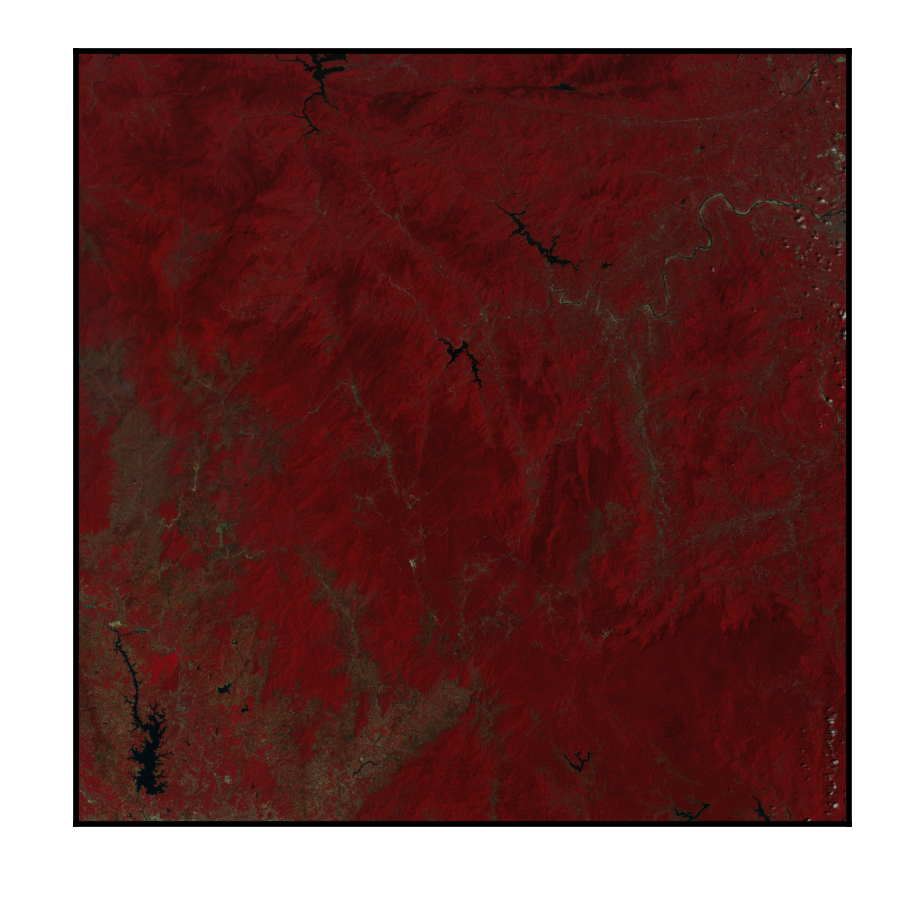

In [ ]:
visual(1,1,1,image2)